In [119]:
import numpy as np
import os
import do_mpc
import casadi
import matplotlib.pyplot as plt
import matplotlib as mpl

from carenv import CarEnv

# Customizing Matplotlib:
mpl.rcParams['axes.grid'] = True


In [120]:
T_STEP = 0.1

## Configure the model

In [121]:
model = do_mpc.model.Model("continuous")

In [122]:
'''
states _x

x_pos
y_pos
theta - heading angle
delta - steering angle
'''
x_pos = model.set_variable(var_type="_x", var_name="x_pos", shape=(1, 1))
y_pos = model.set_variable(var_type="_x", var_name="y_pos", shape=(1, 1))
theta = model.set_variable(var_type="_x", var_name="theta", shape=(1, 1))
delta = model.set_variable(var_type="_x", var_name="delta", shape=(1, 1))

In [123]:
'''
inputs _u

v - velocity
phi - steering rate
'''
v = model.set_variable(var_type="_u", var_name="v")
phi = model.set_variable(var_type="_u", var_name="phi")

In [124]:
'''
parameters _p

L - vehicle length
'''
L = 30

In [125]:
'''
rhs (first order differential equasions of _x)
'''
d_x_pos = v * np.cos(theta)
d_y_pos = v * np.sin(theta)
d_theta = v * np.tan(delta) / L
d_delta = phi

model.set_rhs("x_pos", d_x_pos)
model.set_rhs("y_pos", d_y_pos)
model.set_rhs("theta", d_theta)
model.set_rhs("delta", d_delta)

In [126]:
model.setup()

## MPC setup

In [127]:
SETPOINT = np.array([100, 100, 0])

## Simulator

In [128]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=T_STEP)
simulator.setup()

x0 = np.array([500, 500, 0, 0]).reshape(-1,1)
simulator.x0 = x0

In [129]:
%%capture

sim_graphics = do_mpc.graphics.Graphics(simulator.data)

fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

for g in [sim_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name="x_pos", axis=ax[0])
    g.add_line(var_type='_x', var_name="y_pos", axis=ax[0])
    g.add_line(var_type='_x', var_name="theta", axis=ax[0])
    g.add_line(var_type='_x', var_name="delta", axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name="v", axis=ax[1])
    g.add_line(var_type='_u', var_name="phi", axis=ax[1])


ax[0].set_ylabel('states')
ax[1].set_ylabel('steering')
ax[1].set_xlabel('time [s]')

In [130]:
u0 = np.array([[-20], [0.02]])

sim_time = 50

try:
    with CarEnv(L=L, setpoint=SETPOINT, env_size=(700, 1000), t_step=T_STEP) as env:
        for i in range(int(sim_time * 1/T_STEP)):
            x0 = simulator.make_step(u0)
            env.step(x0)
except:
    pass

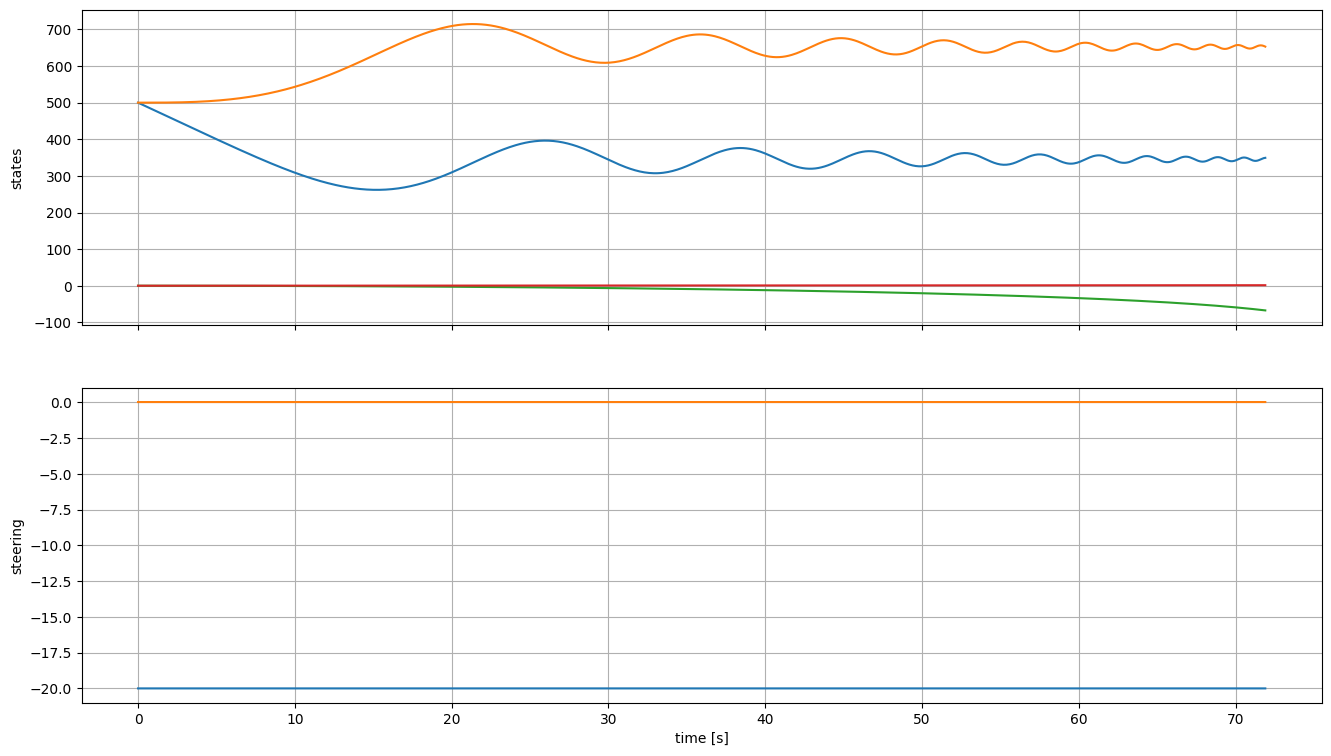

In [118]:
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig